# Project Simulation & Optimization
Given is a rod with cross-section $A$, length $l$ and thermal conductivity $\lambda$, exposed to a constant heat supply $Q_0$ along the rod.

In [74]:
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

The temperature profile is described by the differential equation:  
$T'' + \dfrac{Q_0}{\lambda\,A}=0$  
The analytical solution would be obtained by integrating and using the boundary conditions $T(0)=0$ and $T(l)=0$:  
$T = -\dfrac{Q_0}{2\,\lambda\,A}\,x^2 + \dfrac{Q_0\,l}{2\,\lambda\,A}\,x$

### System Parameters

In [75]:
nodes = 500 # num of nodes for discretization
Q0 = 15 # J/m^2s
lamb = 5 # J/°Cms
Across = 1e-4 # m^2
l = 1 # m

### Analytical Function of $T$

Text(0, 0.5, 'temperature on beam in °C')

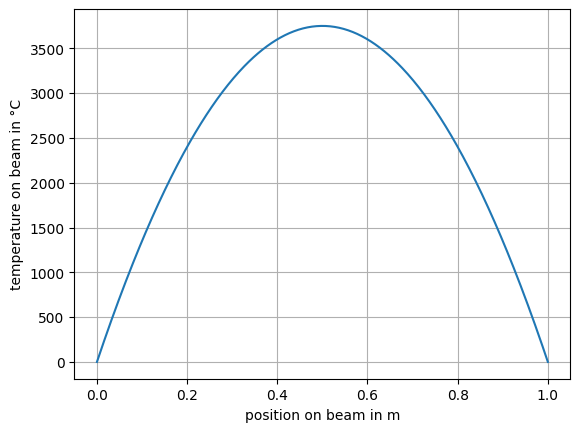

In [76]:
def T(x):
    return -Q0/(2*lamb*Across)*x**2 + Q0/(2*lamb*Across)*x

def T_dd(x):
    return np.ones_like(x)*-Q0/(2*lamb*Across)

x = np.linspace(0, 1, nodes)
T_analytic = T(x)
plt.plot(x, T_analytic)
plt.grid()
plt.xlabel("position on beam in m")
plt.ylabel("temperature on beam in °C")

### System of equations: finite difference method
To make matrix A symmetric, the first and last element are left out (boundary conditions) and added after solving the rest.

In [77]:
n = np.size(x)-2
h = x[1] - x[0]

A = (2*np.eye(n) - np.eye(n, k=1) - np.eye(n, k=-1))

b = np.full(n, Q0 / (lamb * Across))*h**2

print(A)

# sparse matrix representation A ( (row,col) val )
import scipy.sparse as sp
spA = sp.csr_matrix(A)
print(spA)

[[ 2. -1.  0. ...  0.  0.  0.]
 [-1.  2. -1. ...  0.  0.  0.]
 [ 0. -1.  2. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ...  2. -1.  0.]
 [ 0.  0.  0. ... -1.  2. -1.]
 [ 0.  0.  0. ...  0. -1.  2.]]
<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 1492 stored elements and shape (498, 498)>
  Coords	Values
  (0, 0)	2.0
  (0, 1)	-1.0
  (1, 0)	-1.0
  (1, 1)	2.0
  (1, 2)	-1.0
  (2, 1)	-1.0
  (2, 2)	2.0
  (2, 3)	-1.0
  (3, 2)	-1.0
  (3, 3)	2.0
  (3, 4)	-1.0
  (4, 3)	-1.0
  (4, 4)	2.0
  (4, 5)	-1.0
  (5, 4)	-1.0
  (5, 5)	2.0
  (5, 6)	-1.0
  (6, 5)	-1.0
  (6, 6)	2.0
  (6, 7)	-1.0
  (7, 6)	-1.0
  (7, 7)	2.0
  (7, 8)	-1.0
  (8, 7)	-1.0
  (8, 8)	2.0
  :	:
  (489, 489)	2.0
  (489, 490)	-1.0
  (490, 489)	-1.0
  (490, 490)	2.0
  (490, 491)	-1.0
  (491, 490)	-1.0
  (491, 491)	2.0
  (491, 492)	-1.0
  (492, 491)	-1.0
  (492, 492)	2.0
  (492, 493)	-1.0
  (493, 492)	-1.0
  (493, 493)	2.0
  (493, 494)	-1.0
  (494, 493)	-1.0
  (494, 494)	2.0
  (494, 495)	-1.0
  (495, 494)	-1.0
  (495, 495)	2.0
  (49

### Benchmark decorator

In [78]:
import time

# time recorder decorator (inspired by Matthias Panny)
def timedit(func):
    def wrapper(*args, **kwargs):
        #start_time = time.time()
        result = func(*args, **kwargs)
        #end_time = time.time()
        #execution_time = end_time - start_time
        #print(f"Function '{func.__name__}' executed in: {execution_time:.4f} seconds")
        return result
    return wrapper

### Solver implementations

#### helper functions

In [79]:
def backward_sub(U, b):
    n = len(b)
    x = np.zeros(n)
    for i in range(n - 1, -1, -1):
        s = 0.0
        for j in range(i + 1, n):
            s += U[i, j] * x[j]
        x[i] = (b[i] - s) / U[i, i]
    return x

def forward_sub(L, b):
    n = len(b)
    y = np.zeros(n)
    for i in range(n):
        s = 0.0
        for j in range(i):
            s += L[i, j] * y[j]
        y[i] = (b[i] - s) / L[i, i]
    return y

def apply_init_conditions(T, T0, TE):
    T_new = np.zeros(np.size(T)+2)
    T_new[1:-1] = T
    T_new[0] = T0
    T_new[-1] = TE
    return T_new

def is_pos_def(A):
    return np.all(np.linalg.eigvals(A) > 0)

#### Direct solver implementations

In [ ]:
@timedit
def solve_numpy(A,b):
    return np.linalg.solve(A,b)

@timedit
def classic_gauss(A,b):
    A = A.copy().astype(float)
    b = b.copy().astype(float)
    n = len(b)

    # factorization
    for i in range(n - 1):
        for j in range(i + 1, n):
            lji = A[j, i] / A[i, i]

            for k in range(i, n):
                A[j, k] -= lji * A[i, k]

            b[j] -= lji * b[i]

    # back subs.
    x = backward_sub(A,b)
    return x

@timedit
def vector_gauss(A,b):
    A = A.copy().astype(float)
    b = b.copy().astype(float)
    n = len(b)
    V = np.hstack((A, b.reshape(-1,1))) # concatting A & b

    for i in range(n):
        piv = V[i,i] # pivot element

        ls = V[i+1:,i] / piv # vector with scaling fdactors
        V[i+1:,i:] -= V[i,i:] * ls.reshape(-1, 1) # entire matrix below and to right of pivot element at once
        
    x = backward_sub(V[:, :-1], V[:,-1]) # extract A and b from V
    return x
        
@timedit
def cholesky(A,b):
    A = A.copy().astype(float)
    b = b.copy().astype(float)
    C = np.zeros_like(A)
    n = len(b)

    # factorization and decomposition
    for i in range(n):
        c = 0.0
        for k in range(i):
            c += A[i, k] ** 2
        A[i, i] = np.sqrt(A[i, i] - c)

        # below diagonal
        for j in range(i + 1, n):
            c = 0.0
            for k in range(i):
                c += A[i, k] * A[j, k]
            A[j, i] = (A[j, i] - c) / A[i, i]

            C[j, i] = A[j, i]
    
    y = forward_sub(C,b)
    x = backward_sub(C.T, y)

    return x

def tridiagonal_cholesky(A, b):
    A = A.copy().astype(float)
    b = b.copy().astype(float)
    C = np.zeros_like(A)
    n = len(b)

    # factorization and decomposition
    for i in range(n):
        c = A[i, i-1] ** 2
        A[i, i] = np.sqrt(A[i, i] - c)

        # below diagonal
        for j in range(i + 1, i + 2):
            c = 0.0
            for k in range(i):
                c += A[i, k] * A[j, k]
            A[j, i] = (A[j, i] - c) / A[i, i]

            C[j, i] = A[j, i]
    
    y = forward_sub(C,b)
    x = backward_sub(C.T, y)

    return x

@timedit
def thomas_algorithm(A,d): # https://en.wikipedia.org/wiki/Tridiagonal_matrix_algorithm
    A = A.astype(float)
    d = d.astype(float)

    n = len(d)
    x = np.zeros(n)

    a = A.diagonal(-1).copy() # copy so that not read-only
    b = A.diagonal(0).copy()
    c = A.diagonal(1).copy()

    # sweep
    for i in range(1, n):
        w = a[i-1] / b[i-1]
        b[i] -= w * c[i-1]
        d[i] -= w * d[i-1]

    # back sub
    x[n-1] = d[n-1] / b[n-1]
    for i in range(n-2, -1, -1):
        x[i] = (d[i] - c[i] * x[i+1]) / b[i]

    return x

#### iterative solver implementations

In [81]:
@timedit
def richardson_iteration(A, b, x0, theta, nmax):
    x = x0
    tol = 1e-8
    for i in range(nmax):
        r = A @ x - b

        if np.linalg.norm(r) / np.linalg.norm(b) < tol:
            return x
        x = x - theta*r
    
    print("Richardson did not converge!")
    return x

@timedit
def steepest_gradient(A, b, x0, nmax, returnInfo=False):
    n = len(b)
    x = x0
    tol = 1e-8

    r = A @ x - b
    if returnInfo == True: residual = []
    for i in range(nmax):
        alpha = r.T @ r / (r.T @ A @ r)
        x = x - alpha * r
        r = A @ x - b
        if returnInfo == True: residual.append(np.linalg.norm(r) / np.linalg.norm(b))
        if np.linalg.norm(r) / np.linalg.norm(b) < tol:
            if returnInfo == True:
                return x, residual
            else:
                return x
        
    print("Steepest Gradient did not converge!")
    if returnInfo == True:
        return x, residual
    else:
        return x

@timedit
def conjugate_gradient(A, b, x0, nmax, returnInfo=False):
    x = x0
    tol = 1e-8
    r = A @ x - b
    s = -r
    if returnInfo == True: residual = []
    for i in range(nmax):
        alpha = - (s.T @ r / (s.T @ A @ s))
        x = x + alpha*s
        r = A @ x - b

        if returnInfo == True: residual.append(np.linalg.norm(r) / np.linalg.norm(b))
        if np.linalg.norm(r) / np.linalg.norm(b) < tol:
            if returnInfo == True:
                return x, residual
            else:
                return x
        
        beta = r.T @ A @ s / (s.T @ A @ s)
        s = -r + beta*s
    
    print("Conjugate Gradient did not converge!")
    if returnInfo == True:
        return x, residual
    else:
        return x
    

#### Matrix A properties

In [82]:
if np.allclose(A, A.T):
    print("A is symmetric!")
else:
    print("A is not symmetric!")

if is_pos_def(A):
    print("A is positive definite!")
else:
    print("A is not positive definite!")

print(f"Condition number: {np.linalg.cond(A)}") # same as lam_max/lam_min

A is symmetric!
A is positive definite!
Condition number: 100915.63752598783


### Direct Solving

In [88]:
T_numpy = solve_numpy(A, b)
T_numpy = apply_init_conditions(T_numpy, 0, 0)

T_gauss = classic_gauss(A, b)
T_gauss = apply_init_conditions(T_gauss, 0, 0)

T_cholesky = cholesky(A, b)
T_cholesky = apply_init_conditions(T_cholesky, 0, 0)

T_thomas = thomas_algorithm(A, b)
T_thomas = apply_init_conditions(T_thomas, 0, 0)

T_vec_gauss = vector_gauss(A,b)
T_vec_gauss = apply_init_conditions(T_vec_gauss, 0, 0)




#### Iterative Solving

Richardson did not converge!
Steepest Gradient did not converge!


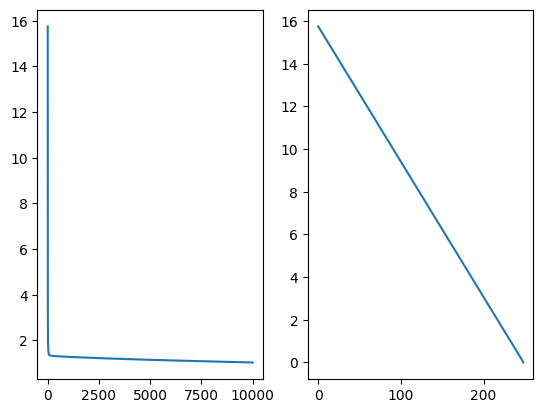

In [84]:
T_richard = richardson_iteration(A, b, np.zeros_like(b), 0.01, 10000)
T_steep_grad, residual_sg = steepest_gradient(A, b, np.zeros_like(b), 10000, returnInfo=True)

T_conj_grad = conjugate_gradient(A, b, np.zeros_like(b), 10000)
T_conj_grad = apply_init_conditions(T_conj_grad, 0, 0)

T_conj_sparse, residual_cg = conjugate_gradient(spA, b, np.zeros_like(b), 10000, returnInfo=True)
T_conj_sparse = apply_init_conditions(T_conj_sparse, 0, 0)

fig, ax = plt.subplots(1,2)
ax[0].plot(residual_sg)
ax[1].plot(residual_cg)
plt.show()

#### Solving benchmark
reduce **nodes** parameter under **System Parameters** [HERE](#system-parameters) if it is taking too long

In [85]:
import timeit
cycles = 5

print("Performance direct solvers:")
print(f"Avg. execution time classic gauss: {timeit.timeit(stmt=lambda: classic_gauss(A,b), number=cycles)/cycles} seconds")
print(f"Avg. execution time cholesky: {timeit.timeit(stmt=lambda: cholesky(A,b), number=cycles)/cycles} seconds")
print(f"Avg. execution time vectorized gauss: {timeit.timeit(stmt=lambda: vector_gauss(A,b), number=cycles)/cycles} seconds")
print(f"Avg. execution time numpy solve: {timeit.timeit(stmt=lambda: solve_numpy(A,b), number=cycles)/cycles} seconds")
print(f"Avg. execution time thomas algorithm: {timeit.timeit(stmt=lambda: thomas_algorithm(A,b), number=cycles)/cycles} seconds")

print("\nPerformance iterative solvers:")
print(f"Avg. execution time conjugate gradient: {timeit.timeit(stmt=lambda: conjugate_gradient(A, b, np.zeros_like(b), 10000), number=cycles)/cycles} seconds")
print(f"Avg. execution time conjugate gradient sparse A: {timeit.timeit(stmt=lambda: conjugate_gradient(spA, b, np.zeros_like(b), 10000), number=cycles)/cycles} seconds")


Performance direct solvers:
Avg. execution time classic gauss: 8.597086180001497 seconds
Avg. execution time cholesky: 3.5240126400021836 seconds
Avg. execution time vectorized gauss: 0.08491993999923579 seconds
Avg. execution time numpy solve: 0.0025550999969709666 seconds
Avg. execution time thomas algorithm: 0.0006000400055199862 seconds

Performance iterative solvers:
Avg. execution time conjugate gradient: 0.02540092000272125 seconds
Avg. execution time conjugate gradient sparse A: 0.012399460002779961 seconds


### Time performance ranking
Every algorithm has been run 5 times in succession with $n=500$, measuring the execution time and taking the average value. The results can be seen in the table below. The values obviously depend on the hardware.

| Ranking | Method                         | Execution time               |
|---------|--------------------------------|------------------------------|
| 1       | Thomas algorithm               | $\approx 0.0012\,\mathrm{s}$ |
| 2       | numpy.linalg.solve             | $\approx 0.0038\,\mathrm{s}$ |
| 3       | Conjugate gradient w. sparse A | $\approx 0.017\,\mathrm{s}$  |
| 4       | Conjugate gradient             | $\approx 0.036\,\mathrm{s}$  |
| 5       | vectorized Gauss               | $\approx 0.14\,\mathrm{s}$   |
| 6       | Cholesky decomp.               | $\approx 4.90\,\mathrm{s}$   |
| 7       | classic Gauss                  | $\approx 12.11\,\mathrm{s}$  |
| 8       | Steepest gradient              | no convergence               |
| 9       | Richardson iteration           | no convergence               |

#### direct solver performance
The classic **Gaussian elimination** algorithm is by far the slowest algorithm to solve this problem, followed by **Cholesky**.

Next in line is a **vectorized Gaussian** implementation, which replaces two of the three for-loops with vector operations, increasing the performance by a factor of ~100.

By far the fastest and most memory efficient implementation for this specific kind of problem (which is called a [tridiagonal matrix](https://en.wikipedia.org/wiki/Tridiagonal_matrix_algorithm)) is the **Thomas-algorithm**. There are only three arrays containing the entries that need to be saved and the time complexity is $\mathcal{O}(n)$

#### iterative solver performance
The **Richardson iteration** and the **steepest gradient method** did not converge when applied to the problem. As $\utilde{A}$ is a SPD-matrix, the steepest gradient should converge; the fact that it did not is probably because of too little steps or due to the problem being "slightly" ill-conditioned ($\kappa\approx 100000$ for $n=500$). The iterative method that worked best is the **conjugate gradient method**.

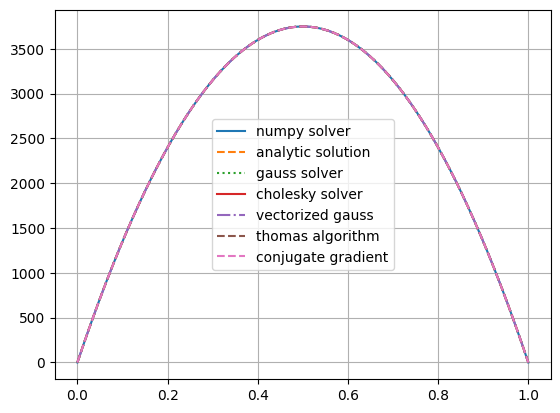

In [86]:
plt.plot(x,T_numpy, label="numpy solver")
plt.plot(x,T_analytic, label="analytic solution", linestyle="--")
plt.plot(x,T_gauss, label="gauss solver", linestyle=":")
plt.plot(x,T_cholesky, label="cholesky solver", linestyle="-")
plt.plot(x,T_vec_gauss, label="vectorized gauss", linestyle="-.")
plt.plot(x,T_thomas, label="thomas algorithm", linestyle="--")
plt.plot(x,T_conj_grad, label="conjugate gradient", linestyle="--")
plt.legend()
plt.grid()